In [1]:
import pandas as pd
import numpy as np
import sklearn.ensemble
import lime.lime_tabular_mod
import matplotlib.pyplot as plt

import importlib
importlib.reload(lime.lime_tabular_mod)

pd.set_option("display.max_columns", None)
pd.set_option("mode.chained_assignment", None)
plt.style.use({"figure.facecolor": "white"})

### Load iris dataset
This dataset will be used as an example

In [2]:
iris_dataset = pd.read_csv(
    "../data/iris-classification/iris.data",
    names=[
        "sepal_length",
        "sepal_width",
        "petal_length",
        "petal_width",
        "label"
    ]).sample(frac=1)
iris_dataset

,sepal_length,sepal_width,petal_length,petal_width,label
55,5.7,2.8,4.5,1.3,Iris-versicolor
106,4.9,2.5,4.5,1.7,Iris-virginica
18,5.7,3.8,1.7,0.3,Iris-setosa
98,5.1,2.5,3.0,1.1,Iris-versicolor
105,7.6,3.0,6.6,2.1,Iris-virginica
...,...,...,...,...,...
124,6.7,3.3,5.7,2.1,Iris-virginica
68,6.2,2.2,4.5,1.5,Iris-versicolor
142,5.8,2.7,5.1,1.9,Iris-virginica
47,4.6,3.2,1.4,0.2,Iris-setosa


### Prepare test set using jackknife method - single data instance
Instance will be used for explaining Random Forest  prediction


In [3]:
labels_column_name = "label"
jackknife_idx = np.random.randint(0, iris_dataset.shape[0])
train_set = iris_dataset.loc[
        iris_dataset.index != jackknife_idx
    ].drop(columns=labels_column_name).values
train_labels = iris_dataset.loc[
        iris_dataset.index != jackknife_idx,
        labels_column_name
    ].values
test_set = iris_dataset.loc[
        iris_dataset.index == jackknife_idx
    ].drop(columns=labels_column_name).values
test_labels = iris_dataset.loc[
        iris_dataset.index == jackknife_idx,
        labels_column_name
    ].values
test_instance = test_set[0]

attributes = iris_dataset.columns.tolist()
attributes.remove(labels_column_name)

random_forest = sklearn.ensemble.RandomForestClassifier(n_estimators = 10)
random_forest.fit(train_set, train_labels)
unique_labels = random_forest.classes_

Get prediction of explained model

In [4]:
prediction = random_forest.predict(test_set)
prediction_probabilities = random_forest.predict_proba(test_set)[0]
print(f"Predicted: {prediction}. Probabilities: {prediction_probabilities}")

Predicted: ['Iris-setosa']. Probabilities: [1. 0. 0.]


## Use modified LIME to explain prediction
### Create explainer object
At first create explainer object that makes use of training data.
It may be used by discretizer inner object and enhance local surrogate's performance.

In [5]:
explainer = lime.lime_tabular_mod.LimeTabularExplainerMod(
    train_set,
    feature_names = attributes,
    class_names = unique_labels,
    discretize_continuous=False,
    sample_around_instance=True
)

### Explain test instance
Print explanations for two labels with the greatest prediction probabilities

,sepal_length,sepal_width,petal_length,petal_width,label
39,5.1,3.4,1.5,0.2,Iris-setosa


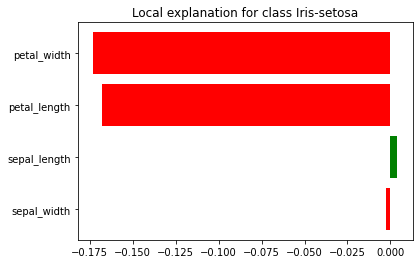

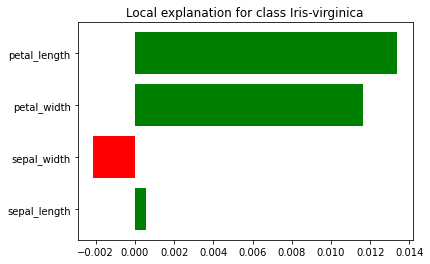

In [6]:
explanation = explainer.explain_instance(
    test_instance,
    random_forest.predict_proba,
    num_features = 4,
    top_labels = 3,
    # distance_metric="minkowski",
    # minkowski_norm=100.
)
for label in explanation.top_labels[:2]:
    _ = explanation.as_pyplot_figure(label)

# show explained instance
iris_dataset.loc[iris_dataset.index == jackknife_idx]

## Assess the explanation

Compare predictions of explained model and local surrogate on explained data instance:

In [7]:
print(explanation.get_prediction_for_explained_model())
print(explanation.get_prediction_for_surrogate_model(normalized=True))


[1.0, 0.0, 0.0]
[0.4977710595075297, 0.2752519660763064, 0.2269769744161639]


Check scores and losses of sub-explainers that are local surrogate consists of:

In [8]:
print(explanation.get_scores_for_surrogate_model())
print(explanation.get_losses_for_surrogate_model())

[0.5042949611677378, 0.4542959940695659, 0.07891902358107605]
[0.04508237977132801, 0.05131190250282022, 0.007486516614763695]


Compare fidelity of local surrogate on explained instance and on the generated dataset.
For fidelity methods MSE (mean square error) is used.

In [9]:
print(explanation.get_fidelity_loss_on_explanation())
print(explanation.get_fidelity_loss_on_generated_data())


0.1265053668040591
0.07960010450444531


Unfortunately, due to the sampling method that is far from perfect,
fidelity loss on explanation is significantly greater.

One can check fidelity loss map for generated data instances:

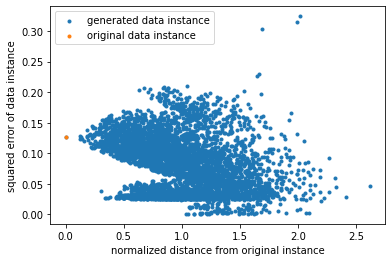

In [10]:
squared_errors = explanation.get_fidelity_loss_distribution()
explanation.plot_fidelity_map()

Histograms of errors and normalised distances from original instance are plotted below:

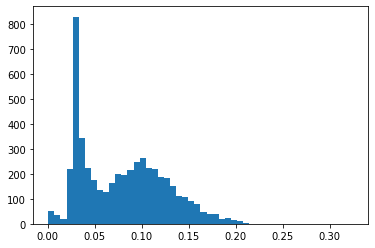

In [11]:
plt.hist(squared_errors, bins=50)
plt.show()

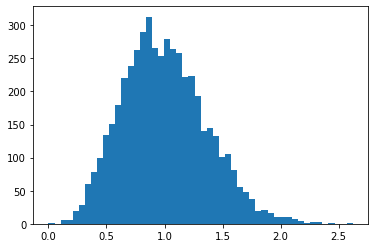

In [12]:
plt.hist((squared_errors.index)/np.mean(squared_errors.index.values), bins=50)
plt.show()

Surprisingly and sadly enough, distribution of distances from generated instances to explained one is
unintuitive. That is the reason why **explained instance is actually the worst explained**.

Knowing that local surrogate explains models only locally, one can check how
**fidelity loss** changes on increasing distance from explained instance
(spatial distribution of fidelity loss).

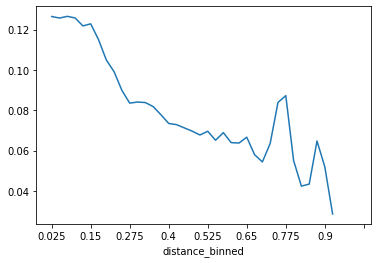

In [13]:
binned = explanation.get_fidelity_loss_distribution(bins=40)
binned.plot()
plt.show()

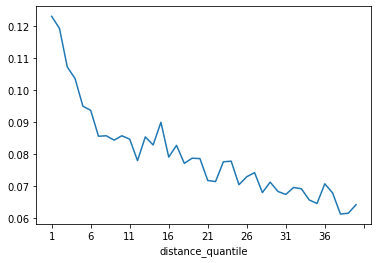

In [14]:
percentiles = explanation.get_fidelity_loss_distribution(quantiles=40)
percentiles.plot()
plt.show()